# Apriori Association Rule Mining - Groceries Dataset

This notebook demonstrates the complete workflow for association rule mining using the Apriori algorithm on the Groceries dataset.

In [3]:
# Clone repository từ GitHub
!git clone https://github.com/VanAnhstudents/apriori-grocery-analysis.git

Cloning into 'apriori-grocery-analysis'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 138 (delta 63), reused 91 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (138/138), 307.52 KiB | 3.89 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [4]:
# Chuyển đến thư mục repository
import os
os.chdir('/content/apriori-grocery-analysis')

In [5]:
# Kiểm tra nội dung thư mục
print("Current directory:", os.getcwd())
print("Contents:")
!ls -la

Current directory: /content/apriori-grocery-analysis
Contents:
total 88
drwxr-xr-x 9 root root  4096 Oct 23 01:46 .
drwxr-xr-x 1 root root  4096 Oct 23 01:42 ..
drwxr-xr-x 2 root root  4096 Oct 23 01:42 app
drwxr-xr-x 8 root root  4096 Oct 23 01:46 apriori-grocery-analysis
-rw-r--r-- 1 root root 15920 Oct 23 01:42 daily_setup.py
drwxr-xr-x 3 root root  4096 Oct 23 01:42 data
drwxr-xr-x 2 root root  4096 Oct 23 01:42 docs
drwxr-xr-x 8 root root  4096 Oct 23 01:42 .git
-rw-r--r-- 1 root root  4970 Oct 23 01:42 .gitignore
-rw-r--r-- 1 root root  1071 Oct 23 01:42 LICENSE
drwxr-xr-x 2 root root  4096 Oct 23 01:42 notebooks
-rw-r--r-- 1 root root 13745 Oct 23 01:42 push_to_github.py
-rw-r--r-- 1 root root   941 Oct 23 01:42 README.md
-rw-r--r-- 1 root root   103 Oct 23 01:42 requirements.txt
drwxr-xr-x 2 root root  4096 Oct 23 01:42 src


In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!python daily_setup.py

🚀 SETUP PHIÊN LÀM VIỆC MỚI

🔍 KIỂM TRA HỆ THỐNG

📌 Kiểm tra Python version...
Python 3.12.12

✅ Python 3.12.12

📌 Kiểm tra pip...
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)

✅ Pip có sẵn

📌 Kiểm tra Git...
git version 2.34.1

✅ git version 2.34.1

🔍 Phát hiện môi trường Google Colab
✅ Google Drive đã được mount
Đường dẫn đến project trên Drive [/content/drive/MyDrive/project]: /content/drive/MyDrive/apriori-grocery-analysis
✅ Đã chuyển đến: /content/drive/MyDrive/apriori-grocery-analysis

📌 Kiểm tra Git repository...

⚠️  Chưa phải Git repository
Khởi tạo Git repository? (y/n) [n]: y

📌 Khởi tạo Git repository...
Initialized empty Git repository in /content/drive/MyDrive/apriori-grocery-analysis/.git/

Nhập URL remote repository (hoặc Enter để bỏ qua): https://github.com/VanAnhstudents/apriori-grocery-analysis.git

📌 Thêm remote repository...

🔧 Kiểm tra Git configuration...

📌 Lấy Git username...

📌 Lấy Git email...

⚠️  Git user chưa được cấu hình
Nhập 

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys
import os
from itertools import combinations
from collections import defaultdict
from typing import List, Set, Tuple, Dict, Any

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [14]:
# Add current directory to path để import các module
sys.path.append('/content/apriori-grocery-analysis')

# Import các module từ source code
try:
    from src.data_preprocessing import DataPreprocessor
    from src.apriori import Apriori
    from src.visualization import DataVisualizer
    from src.utils import save_results, print_summary
    print("✅ Successfully imported modules from src/")
except ImportError as e:
    print(f"❌ Error importing modules: {e}")
    print("Trying to import from current directory...")

    # Fallback: định nghĩa các class trực tiếp trong notebook
    print("Using fallback definitions...")

    # Định nghĩa DataPreprocessor (giống như trong file data_preprocessing.py)
    class DataPreprocessor:
        def __init__(self):
            self.data = None
            self.transactions = None

        def load_data(self, file_path: str) -> pd.DataFrame:
            try:
                self.data = pd.read_csv(file_path)
                print(f"Dataset loaded successfully with {len(self.data)} rows and {len(self.data.columns)} columns")
                return self.data
            except Exception as e:
                print(f"Error loading dataset: {e}")
                return None

        def prepare_transactions(self) -> List[List[str]]:
            if self.data is None:
                print("No data loaded")
                return []

            if 'itemDescription' not in self.data.columns:
                print("Error: 'itemDescription' column not found in dataset")
                print(f"Available columns: {self.data.columns.tolist()}")
                return []

            self.data['itemDescription'] = self.data['itemDescription'].str.strip().str.lower()

            transaction_column = None

            if 'Member_number' in self.data.columns and 'Date' in self.data.columns:
                self.data['Transaction_ID'] = self.data['Member_number'].astype(str) + '_' + self.data['Date']
                transaction_column = 'Transaction_ID'
                print("Using Member_number + Date as transaction identifier")
            elif 'Transaction' in self.data.columns:
                transaction_column = 'Transaction'
                print("Using Transaction column as transaction identifier")
            else:
                print("Warning: No transaction identifier found. Using each row as a separate transaction.")
                transactions = [[item] for item in self.data['itemDescription'].values]
                self.transactions = transactions
                print(f"Created {len(transactions)} single-item transactions")
                return transactions

            transactions = self.data.groupby(transaction_column)['itemDescription'].apply(list).tolist()
            multi_item_transactions = [t for t in transactions if len(t) > 1]

            print(f"Original transactions: {len(transactions)}")
            print(f"Multi-item transactions: {len(multi_item_transactions)}")

            if len(multi_item_transactions) < len(transactions):
                print(f"Filtered out {len(transactions) - len(multi_item_transactions)} single-item transactions")

            self.transactions = multi_item_transactions

            if self.transactions:
                transaction_lengths = [len(t) for t in self.transactions]
                print(f"Average items per transaction: {np.mean(transaction_lengths):.2f}")
                print(f"Max items per transaction: {max(transaction_lengths)}")
                print(f"Min items per transaction: {min(transaction_lengths)}")

            return self.transactions

        def get_frequent_items(self, top_n: int = 20) -> pd.Series:
            if self.data is None:
                print("No data loaded")
                return pd.Series()

            if 'itemDescription' not in self.data.columns:
                print("Error: 'itemDescription' column not found")
                return pd.Series()

            item_counts = self.data['itemDescription'].value_counts().head(top_n)
            return item_counts

        def analyze_transaction_patterns(self):
            if self.transactions is None:
                print("No transactions prepared")
                return

            transaction_lengths = [len(t) for t in self.transactions]

            print("\n=== Transaction Pattern Analysis ===")
            print(f"Total transactions: {len(self.transactions)}")
            print(f"Average items per transaction: {np.mean(transaction_lengths):.2f}")
            print(f"Standard deviation: {np.std(transaction_lengths):.2f}")
            print(f"Max items: {max(transaction_lengths)}")
            print(f"Min items: {min(transaction_lengths)}")

            recommended_support = max(0.001, 1 / (len(self.transactions) * 0.1))
            print(f"Recommended min_support: {recommended_support:.4f}")
            print(f"Recommended min_confidence: 0.3 - 0.5")

✅ Successfully imported modules from src/


In [15]:
# Định nghĩa Apriori class nếu import không thành công
try:
    from src.apriori import Apriori
    print("✅ Apriori class imported successfully")
except:
    print("Using fallback Apriori class definition...")

    class Apriori:
        def __init__(self, min_support: float = 0.01, min_confidence: float = 0.5):
            self.min_support = min_support
            self.min_confidence = min_confidence
            self.frequent_itemsets = {}
            self.association_rules = []

        def _get_frequent_1_itemsets(self, transactions: List[List[str]]) -> Dict[frozenset, float]:
            item_counts = defaultdict(int)
            total_transactions = len(transactions)

            for transaction in transactions:
                for item in transaction:
                    item_counts[item] += 1

            frequent_1_itemsets = {}
            for item, count in item_counts.items():
                support = count / total_transactions
                if support >= self.min_support:
                    frequent_1_itemsets[frozenset([item])] = support

            print(f"Found {len(frequent_1_itemsets)} frequent 1-itemsets")
            return frequent_1_itemsets

        def _has_infrequent_subset(self, candidate: Set, prev_frequent: Dict) -> bool:
            k = len(candidate)
            if k <= 1:
                return False

            subsets = combinations(candidate, k - 1)
            for subset in subsets:
                if frozenset(subset) not in prev_frequent:
                    return True
            return False

        def _apriori_gen(self, prev_frequent: Dict, k: int) -> Set[frozenset]:
            candidates = set()
            prev_itemsets = list(prev_frequent.keys())

            for i in range(len(prev_itemsets)):
                for j in range(i + 1, len(prev_itemsets)):
                    itemset1 = prev_itemsets[i]
                    itemset2 = prev_itemsets[j]
                    union_set = itemset1.union(itemset2)
                    if len(union_set) == k:
                        if not self._has_infrequent_subset(union_set, prev_frequent):
                            candidates.add(frozenset(union_set))

            return candidates

        def _calculate_support(self, itemset: Set, transactions: List[List[str]]) -> float:
            count = 0
            for transaction in transactions:
                if itemset.issubset(set(transaction)):
                    count += 1
            return count / len(transactions)

        def find_frequent_itemsets(self, transactions: List[List[str]]) -> Dict[int, Dict[frozenset, float]]:
            print("Finding frequent itemsets...")
            self.frequent_itemsets = {}

            if not transactions:
                print("No transactions provided")
                return {}

            self.frequent_itemsets[1] = self._get_frequent_1_itemsets(transactions)

            if not self.frequent_itemsets[1]:
                print("No frequent 1-itemsets found. Try lowering min_support.")
                return {}

            k = 2
            while self.frequent_itemsets[k - 1]:
                candidates = self._apriori_gen(self.frequent_itemsets[k - 1], k)
                frequent_k = {}

                for candidate in candidates:
                    support = self._calculate_support(candidate, transactions)
                    if support >= self.min_support:
                        frequent_k[candidate] = support

                self.frequent_itemsets[k] = frequent_k
                print(f"Found {len(frequent_k)} frequent {k}-itemsets")

                if not frequent_k:
                    break
                k += 1

            self.frequent_itemsets = {k: v for k, v in self.frequent_itemsets.items() if v}
            total_itemsets = sum(len(itemsets) for itemsets in self.frequent_itemsets.values())
            print(f"Total frequent itemsets found: {total_itemsets}")
            return self.frequent_itemsets

        def generate_rules(self, transactions: List[List[str]]) -> List[Dict[str, Any]]:
            print("Generating association rules...")

            if not self.frequent_itemsets:
                self.find_frequent_itemsets(transactions)

            if not self.frequent_itemsets:
                return []

            rules = []
            total_transactions = len(transactions)

            for k, itemsets in self.frequent_itemsets.items():
                if k < 2:
                    continue

                for itemset, support in itemsets.items():
                    itemset_list = list(itemset)
                    for i in range(1, len(itemset_list)):
                        for antecedent in combinations(itemset_list, i):
                            antecedent = frozenset(antecedent)
                            consequent = itemset - antecedent

                            if not consequent:
                                continue

                            antecedent_count = sum(1 for transaction in transactions
                                                   if antecedent.issubset(set(transaction)))
                            if antecedent_count == 0:
                                continue

                            confidence = (support * total_transactions) / antecedent_count

                            if confidence >= self.min_confidence:
                                consequent_count = sum(1 for transaction in transactions
                                                       if consequent.issubset(set(transaction)))
                                consequent_support = consequent_count / total_transactions

                                if consequent_support > 0:
                                    lift = confidence / consequent_support
                                else:
                                    lift = float('inf')

                                if confidence == 1:
                                    conviction = float('inf')
                                else:
                                    conviction = (1 - consequent_support) / (1 - confidence)

                                rules.append({
                                    'antecedent': set(antecedent),
                                    'consequent': set(consequent),
                                    'support': support,
                                    'confidence': confidence,
                                    'lift': lift,
                                    'conviction': conviction
                                })

            rules.sort(key=lambda x: x['confidence'], reverse=True)
            self.association_rules = rules
            print(f"Generated {len(rules)} association rules")
            return rules

        def get_rules_dataframe(self) -> pd.DataFrame:
            if not self.association_rules:
                return pd.DataFrame()

            data = []
            for rule in self.association_rules:
                data.append({
                    'Antecedent': ' & '.join(rule['antecedent']),
                    'Consequent': ' & '.join(rule['consequent']),
                    'Support': f"{rule['support']:.4f}",
                    'Confidence': f"{rule['confidence']:.4f}",
                    'Lift': f"{rule['lift']:.4f}",
                    'Conviction': f"{rule['conviction']:.4f}" if rule['conviction'] != float('inf') else 'inf'
                })

            return pd.DataFrame(data)

✅ Apriori class imported successfully


In [16]:
# Tạo instance của DataPreprocessor
preprocessor = DataPreprocessor()

# Tải dữ liệu - sử dụng đường dẫn tương đối trong repository
file_path = 'data/Groceries_dataset.csv'  # Đường dẫn trong repository

# Kiểm tra xem file có tồn tại không
if not os.path.exists(file_path):
    print(f"File {file_path} not found. Available files:")
    !find . -name "*.csv" -type f
    # Thử đường dẫn khác
    file_path = './Groceries_dataset.csv'
    if not os.path.exists(file_path):
        file_path = 'Groceries_dataset.csv'

print(f"Loading data from: {file_path}")
data = preprocessor.load_data(file_path)

# Hiển thị thông tin cơ bản về dataset
if data is not None:
    print("\n=== Dataset Information ===")
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")

    print("\n=== Data Sample ===")
    display(data.head())

    print("\n=== Data Types ===")
    print(data.dtypes)

    print("\n=== Missing Values ===")
    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])
else:
    print("❌ Failed to load data")
    # Tạo dữ liệu mẫu để demo
    print("Creating sample data for demonstration...")
    sample_data = {
        'Member_number': [1, 1, 2, 2, 3, 3, 3],
        'Date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02', '2023-01-03', '2023-01-03', '2023-01-03'],
        'itemDescription': ['milk', 'bread', 'milk', 'butter', 'bread', 'butter', 'cheese']
    }
    data = pd.DataFrame(sample_data)
    preprocessor.data = data
    display(data.head())

Loading data from: data/Groceries_dataset.csv
Dataset loaded successfully with 38765 rows and 3 columns

=== Dataset Information ===
Shape: (38765, 3)
Columns: ['Member_number', 'Date', 'itemDescription']

=== Data Sample ===


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk



=== Data Types ===
Member_number       int64
Date               object
itemDescription    object
dtype: object

=== Missing Values ===
Series([], dtype: int64)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Member_number'].plot(kind='hist', bins=20, title='Member_number')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('itemDescription').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Member_number', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Member_number']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Member_number')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Member_number']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('itemDescription')):
  _plot_series(series, series_name, i)
  fig.legend(title='itemDescription', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Member_number')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('itemDescription')):
  _plot_series(series, series_name, i)
  fig.legend(title='itemDescription', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Member_number'].plot(kind='line', figsize=(8, 4), title='Member_number')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['itemDescription'].value_counts()
    for x_label, grp in _df_11.groupby('Date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Date')
_ = plt.ylabel('itemDescription')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['itemDescription'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='index', y='itemDescription', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Member_number', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['itemDescription'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Member_number', y='itemDescription', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [17]:
# Chuẩn bị transactions
print("\n=== Preparing Transactions ===")
transactions = preprocessor.prepare_transactions()

# Phân tích patterns
preprocessor.analyze_transaction_patterns()

# Lấy các items phổ biến
print("\n=== Most Frequent Items ===")
item_counts = preprocessor.get_frequent_items(20)
print(item_counts)


=== Preparing Transactions ===
Using Member_number + Date as transaction identifier
Original transactions: 14963
Multi-item transactions (can generate rules): 14963
Average items per transaction: 2.59
Max items per transaction: 11
Min items per transaction: 2
Sample transactions:
  Transaction 1: ['sausage', 'whole milk', 'semi-finished bread', 'yogurt']
  Transaction 2: ['whole milk', 'pastry', 'salty snack']
  Transaction 3: ['canned beer', 'misc. beverages']

=== Transaction Pattern Analysis ===
Total transactions: 14963
Average items per transaction: 2.59
Standard deviation: 1.12
Max items: 11
Min items: 2
Recommended min_support: 0.0010
Recommended min_confidence: 0.3 - 0.5

=== Most Frequent Items ===
itemDescription
whole milk            2502
other vegetables      1898
rolls/buns            1716
soda                  1514
yogurt                1334
root vegetables       1071
tropical fruit        1032
bottled water          933
sausage                924
citrus fruit           

✅ DataVisualizer imported successfully


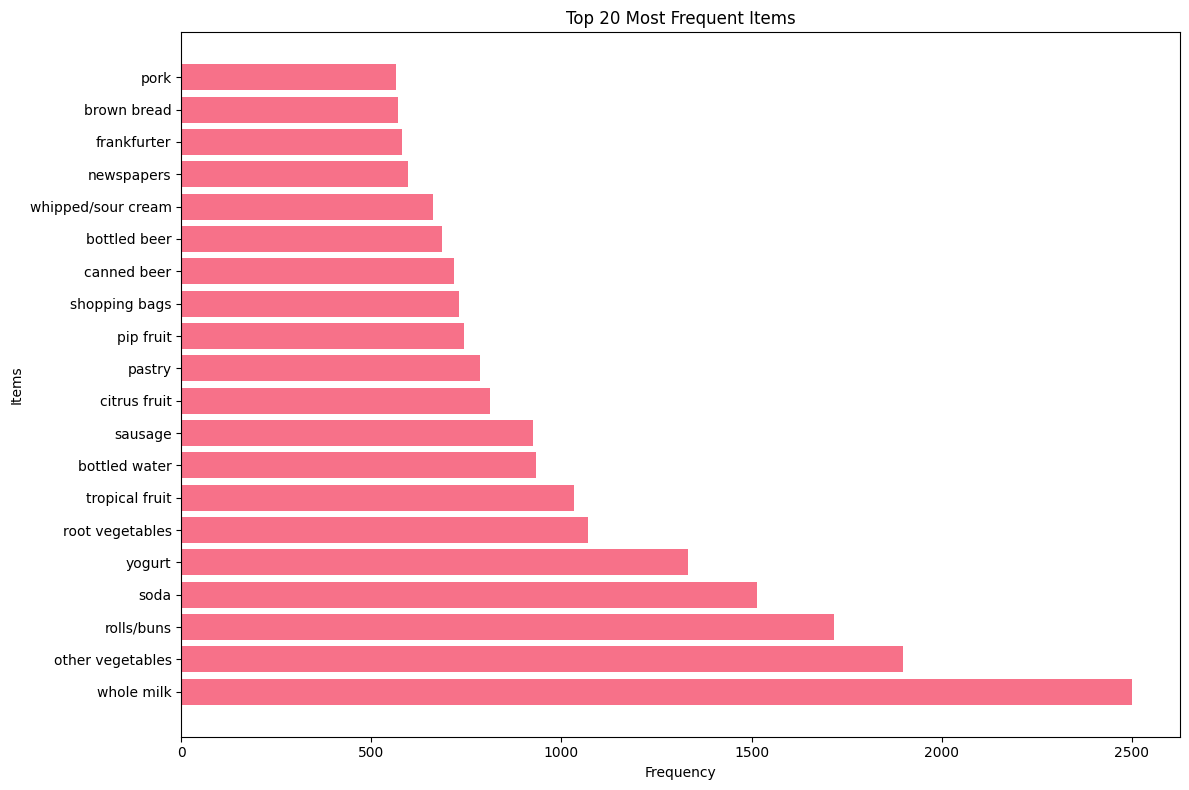

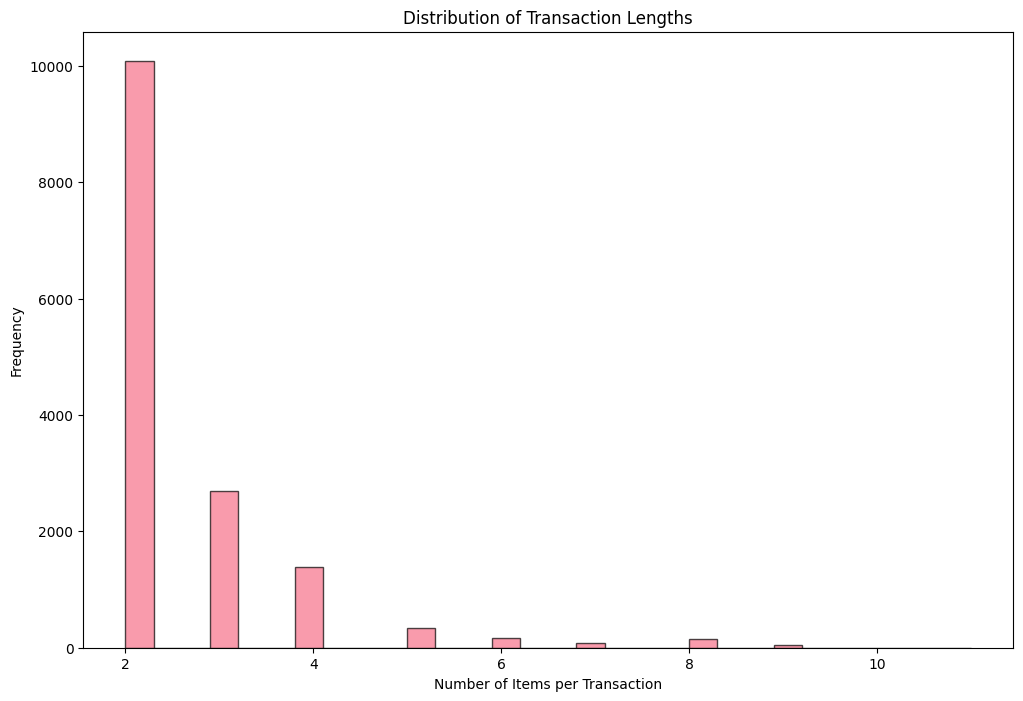

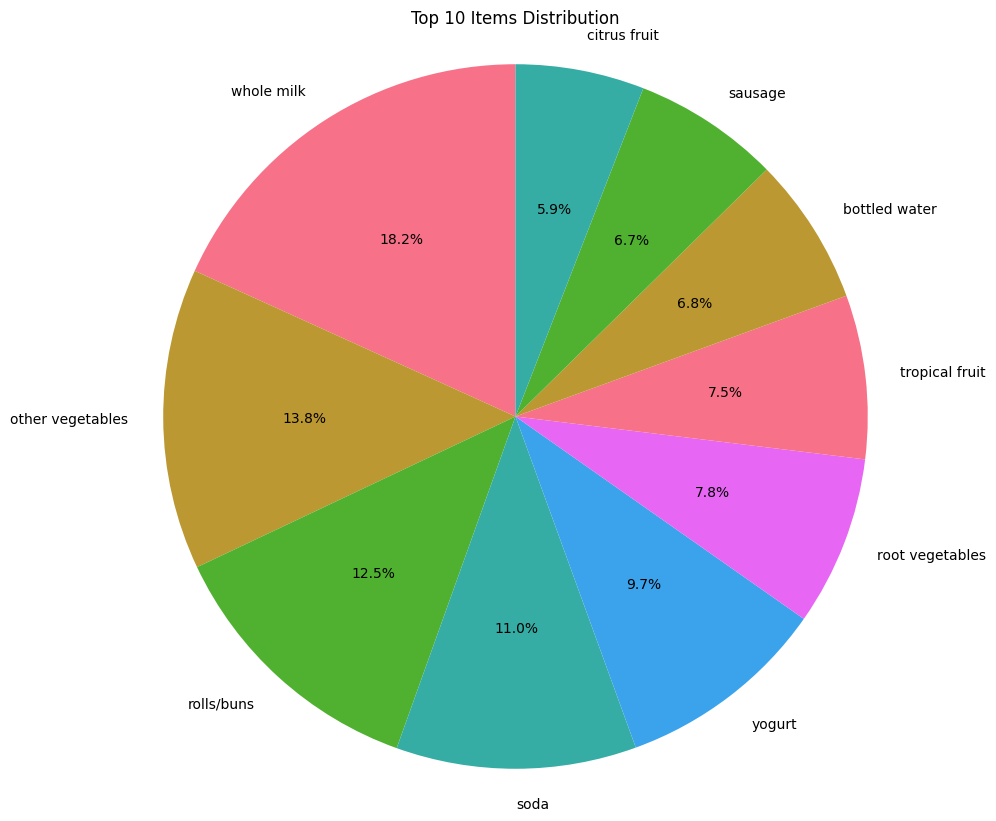

In [18]:
# Import visualization
try:
    from src.visualization import DataVisualizer
    visualizer = DataVisualizer()
    print("✅ DataVisualizer imported successfully")
except:
    print("Using fallback DataVisualizer...")

    class DataVisualizer:
        def __init__(self):
            plt.style.use('default')
            self.fig_size = (12, 8)
            sns.set_palette("husl")

        def plot_top_items(self, item_counts: pd.Series, top_n: int = 20):
            fig, ax = plt.subplots(figsize=self.fig_size)
            top_items = item_counts.head(top_n)
            ax.barh(range(len(top_items)), top_items.values)
            ax.set_yticks(range(len(top_items)))
            ax.set_yticklabels(top_items.index)
            ax.set_xlabel('Frequency')
            ax.set_ylabel('Items')
            ax.set_title(f'Top {top_n} Most Frequent Items')
            plt.tight_layout()
            return fig

        def plot_transaction_length_distribution(self, transactions: List[List[str]]):
            transaction_lengths = [len(transaction) for transaction in transactions]
            fig, ax = plt.subplots(figsize=self.fig_size)
            ax.hist(transaction_lengths, bins=30, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Number of Items per Transaction')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution of Transaction Lengths')
            return fig

        def plot_pie_chart_top_items(self, item_counts: pd.Series, top_n: int = 10):
            fig, ax = plt.subplots(figsize=(10, 10))
            top_items = item_counts.head(top_n)
            ax.pie(top_items.values, labels=top_items.index, autopct='%1.1f%%', startangle=90)
            ax.axis('equal')
            ax.set_title(f'Top {top_n} Items Distribution')
            return fig

    visualizer = DataVisualizer()

# Vẽ biểu đồ items phổ biến
if not item_counts.empty:
    fig1 = visualizer.plot_top_items(item_counts, 20)
    plt.show()

# Vẽ biểu đồ phân phối transaction lengths
if transactions:
    fig2 = visualizer.plot_transaction_length_distribution(transactions)
    plt.show()

    # Vẽ pie chart top 10 items
    fig3 = visualizer.plot_pie_chart_top_items(item_counts, 10)
    plt.show()

In [31]:
# Thiết lập tham số
min_support = 0.01 # @param {type:"number"}
min_confidence = 0.1 # @param {type:"number"}

print(f"\n=== Running Apriori Algorithm ===")
print(f"Parameters: min_support={min_support}, min_confidence={min_confidence}")

# Tạo instance Apriori
apriori_algo = Apriori(min_support=min_support, min_confidence=min_confidence)

# Tìm frequent itemsets
frequent_itemsets = apriori_algo.find_frequent_itemsets(transactions)

# Tạo association rules
rules = apriori_algo.generate_rules(transactions)


=== Running Apriori Algorithm ===
Parameters: min_support=0.01, min_confidence=0.1
Finding frequent itemsets...
Total transactions: 14963
Min support: 0.01
Item frequencies (top 20):
  whole milk: 2502 transactions, support = 0.1672
  other vegetables: 1898 transactions, support = 0.1268
  rolls/buns: 1716 transactions, support = 0.1147
  soda: 1514 transactions, support = 0.1012
  yogurt: 1334 transactions, support = 0.0892
  root vegetables: 1071 transactions, support = 0.0716
  tropical fruit: 1032 transactions, support = 0.0690
  bottled water: 933 transactions, support = 0.0624
  sausage: 924 transactions, support = 0.0618
  citrus fruit: 812 transactions, support = 0.0543
  pastry: 785 transactions, support = 0.0525
  pip fruit: 744 transactions, support = 0.0497
  shopping bags: 731 transactions, support = 0.0489
  canned beer: 717 transactions, support = 0.0479
  bottled beer: 687 transactions, support = 0.0459
  whipped/sour cream: 662 transactions, support = 0.0442
  newspap

In [32]:
# Hiển thị kết quả
if rules:
    print(f"\n=== Association Rules Found: {len(rules)} ===")

    # Chuyển rules thành DataFrame để hiển thị đẹp
    rules_df = apriori_algo.get_rules_dataframe()
    display(rules_df.head(20))

    # Thống kê tổng quan
    print(f"\n=== Summary ===")
    total_itemsets = sum(len(itemsets) for itemsets in frequent_itemsets.values())
    print(f"Total frequent itemsets: {total_itemsets}")
    print(f"Total association rules: {len(rules)}")

    if rules:
        print(f"Highest confidence: {rules[0]['confidence']:.4f}")
        print(f"Highest lift: {max(r['lift'] for r in rules):.4f}")

    # Hiển thị top rules
    print(f"\n=== Top 10 Rules by Confidence ===")
    for i, rule in enumerate(rules[:10]):
        print(f"{i+1}. IF {rule['antecedent']} THEN {rule['consequent']}")
        print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")
        print()
else:
    print("\n❌ No association rules found!")
    print("💡 Try lowering min_support and min_confidence parameters")
    print("💡 Current parameters:")
    print(f"   - min_support: {min_support}")
    print(f"   - min_confidence: {min_confidence}")


=== Association Rules Found: 4 ===


,Antecedent,Consequent,Support,Confidence,Lift,Conviction
0,yogurt,whole milk,0.0112,0.1300,0.8229,0.9679
1,rolls/buns,whole milk,0.0140,0.1270,0.8040,0.9646
2,other vegetables,whole milk,0.0148,0.1215,0.7694,0.9586
3,soda,whole milk,0.0116,0.1198,0.7583,0.9566



=== Summary ===
Total frequent itemsets: 69
Total association rules: 4
Highest confidence: 0.1300
Highest lift: 0.8229

=== Top 10 Rules by Confidence ===
1. IF {'yogurt'} THEN {'whole milk'}
   Support: 0.0112, Confidence: 0.1300, Lift: 0.8229

2. IF {'rolls/buns'} THEN {'whole milk'}
   Support: 0.0140, Confidence: 0.1270, Lift: 0.8040

3. IF {'other vegetables'} THEN {'whole milk'}
   Support: 0.0148, Confidence: 0.1215, Lift: 0.7694

4. IF {'soda'} THEN {'whole milk'}
   Support: 0.0116, Confidence: 0.1198, Lift: 0.7583




=== Visualizing Results ===


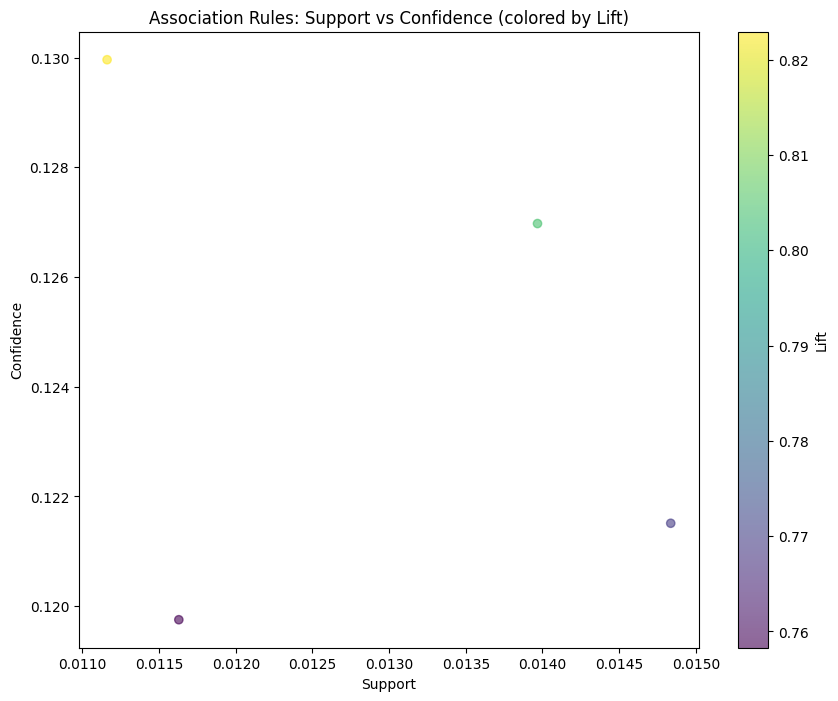

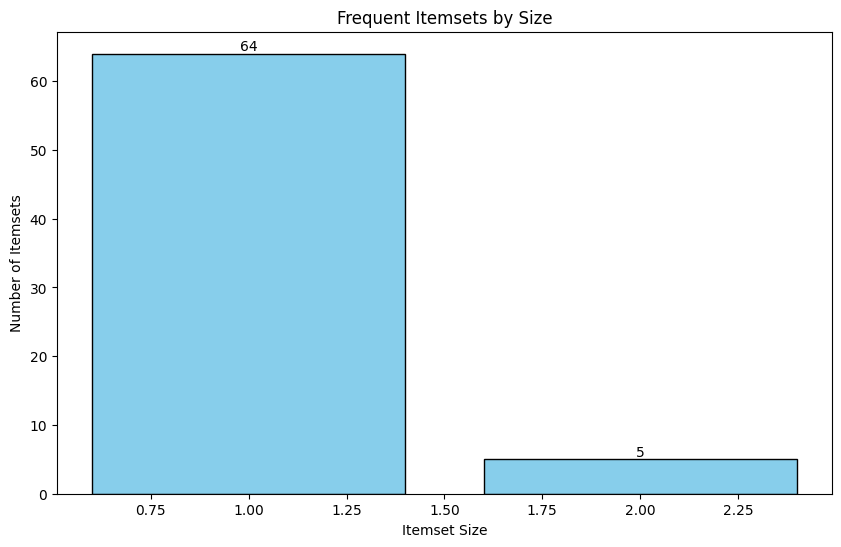

In [33]:
# Trực quan hóa kết quả
if rules and frequent_itemsets:
    print("\n=== Visualizing Results ===")

    # Support vs Confidence scatter plot
    try:
        fig1 = visualizer.plot_rules_metrics(rules)
        plt.show()
    except:
        print("Could not create rules metrics plot")

    # Itemset sizes
    try:
        fig2 = visualizer.plot_itemset_sizes(frequent_itemsets)
        plt.show()
    except:
        # Fallback visualization
        sizes = list(frequent_itemsets.keys())
        counts = [len(itemsets) for itemsets in frequent_itemsets.values()]
        plt.figure(figsize=(10, 6))
        plt.bar(sizes, counts, color='skyblue', edgecolor='black')
        plt.xlabel('Itemset Size')
        plt.ylabel('Number of Itemsets')
        plt.title('Frequent Itemsets by Size')
        for i, count in enumerate(counts):
            plt.text(sizes[i], count, str(count), ha='center', va='bottom')
        plt.show()

In [34]:
# Lưu kết quả
if rules:
    output_dir = 'results'
    os.makedirs(output_dir, exist_ok=True)

    # Lưu rules thành CSV
    rules_df = apriori_algo.get_rules_dataframe()
    rules_csv_path = os.path.join(output_dir, 'association_rules.csv')
    rules_df.to_csv(rules_csv_path, index=False)
    print(f"✅ Rules saved to: {rules_csv_path}")

    # Lưu frequent itemsets
    itemset_data = []
    for k, itemsets in frequent_itemsets.items():
        for itemset, support in itemsets.items():
            itemset_data.append({
                'Itemset': ' & '.join(itemset),
                'Size': k,
                'Support': support
            })

    itemset_df = pd.DataFrame(itemset_data)
    itemset_csv_path = os.path.join(output_dir, 'frequent_itemsets.csv')
    itemset_df.to_csv(itemset_csv_path, index=False)
    print(f"✅ Frequent itemsets saved to: {itemset_csv_path}")

    print(f"\n🎉 Analysis completed successfully!")
    print(f"📊 Total rules found: {len(rules)}")
    print(f"📁 Results saved in: {output_dir}")

    # Hiển thị nội dung thư mục kết quả
    print(f"\n📂 Contents of {output_dir}:")
    !ls -la {output_dir}
else:
    print("No results to save")

✅ Rules saved to: results/association_rules.csv
✅ Frequent itemsets saved to: results/frequent_itemsets.csv

🎉 Analysis completed successfully!
📊 Total rules found: 4
📁 Results saved in: results

📂 Contents of results:
total 16
drwxr-xr-x  2 root root 4096 Oct 23 02:00 .
drwxr-xr-x 10 root root 4096 Oct 23 02:00 ..
-rw-r--r--  1 root root  253 Oct 23 02:23 association_rules.csv
-rw-r--r--  1 root root 2404 Oct 23 02:23 frequent_itemsets.csv
